model library install
```bash
pip install git+https://github.com/abcd-EGH/srnn-ae.git
```

In [49]:
!pip uninstall srnn-ae -q -y

In [50]:
!pip install git+https://github.com/abcd-EGH/srnn-ae.git -q

In [51]:
!pip show srnn-ae

Name: srnn-ae
Version: 0.1.10
Summary: Sparsely connections RNN + AutoEncoder Model for Anomaly Detection in Time Series
Home-page: https://github.com/abcd-EGH/srnn-ae
Author: Jihwan Lee (abcd-EGH)
Author-email: wlghks7790@gmail.com
License: MIT
Location: C:\Users\Jihwan\anaconda3\envs\ml_env\Lib\site-packages
Requires: numpy, pandas, scikit-learn, torch
Required-by: 


In [1]:
from srnn_ae import SLAEE, set_random_seed, hyperparameter_setting, read_dataset
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    roc_auc_score, average_precision_score, cohen_kappa_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import time

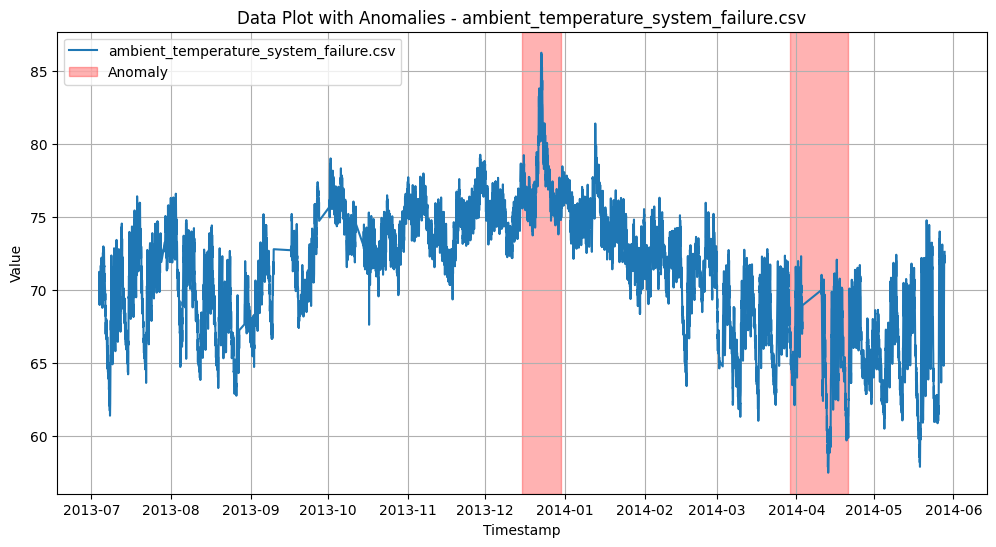

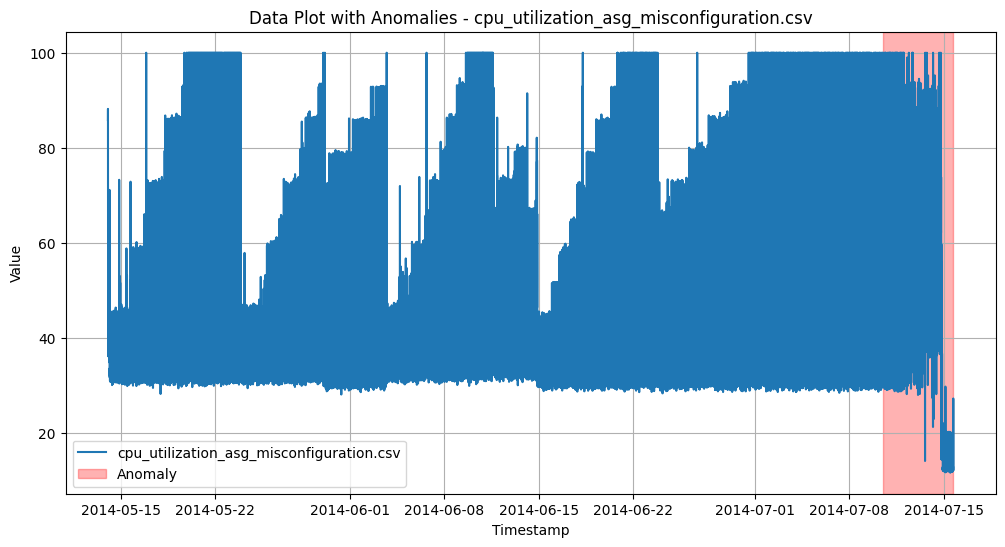

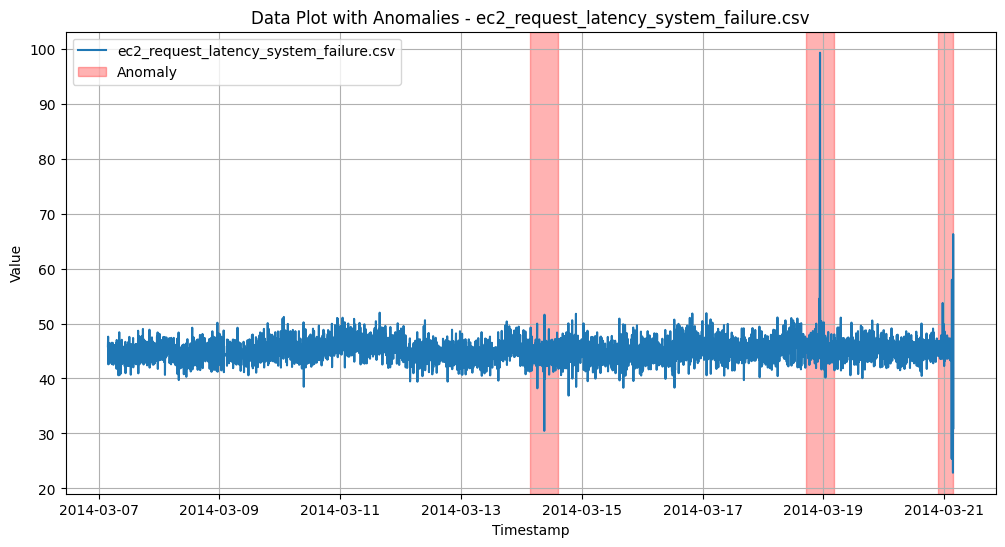

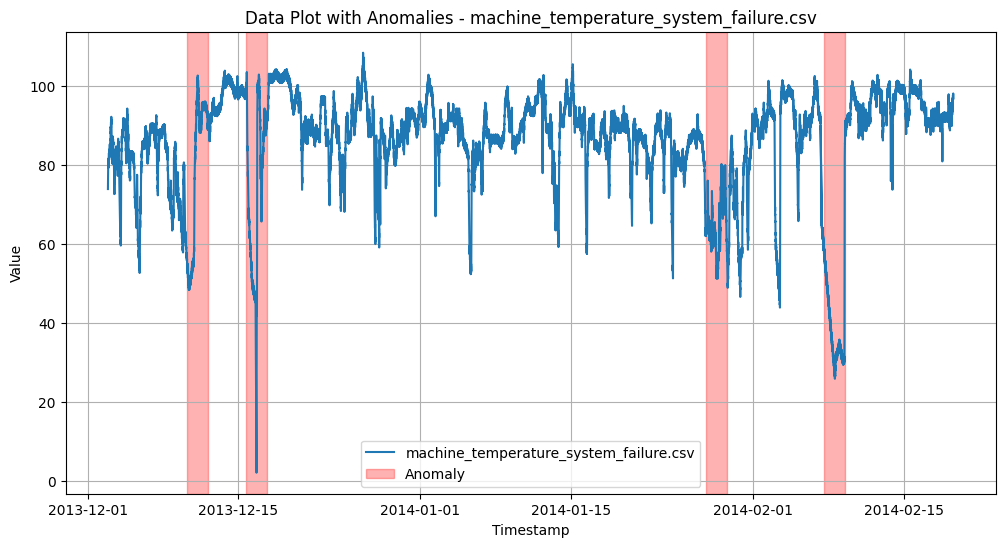

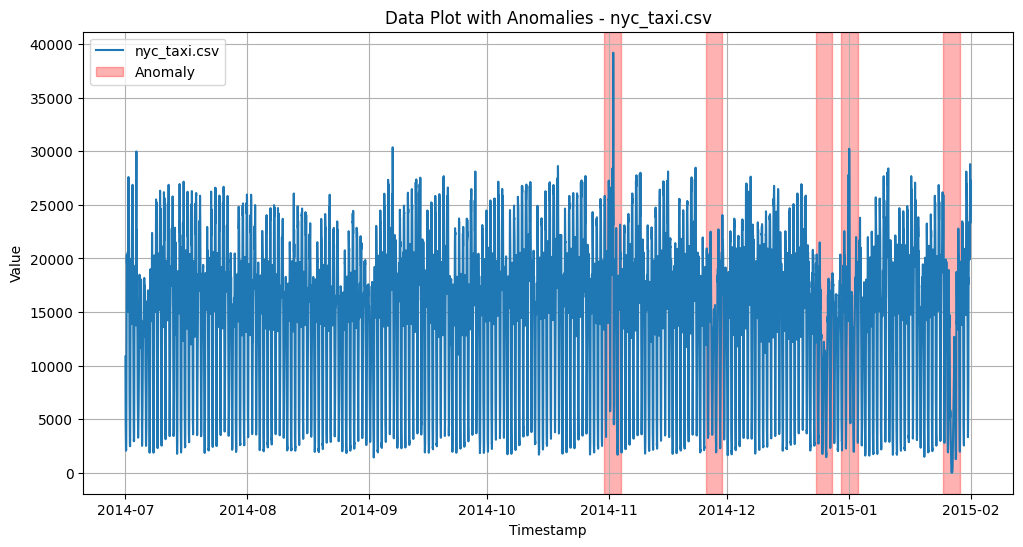

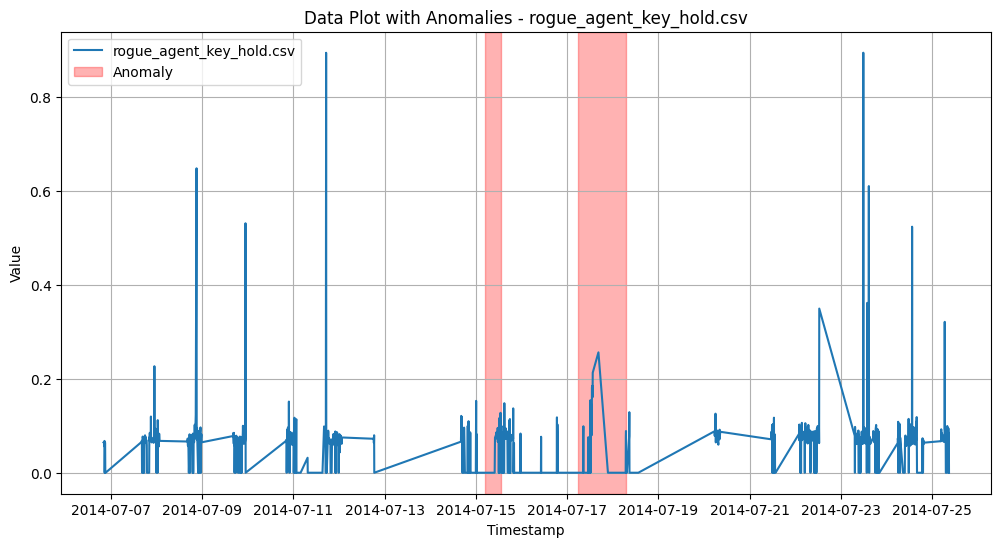

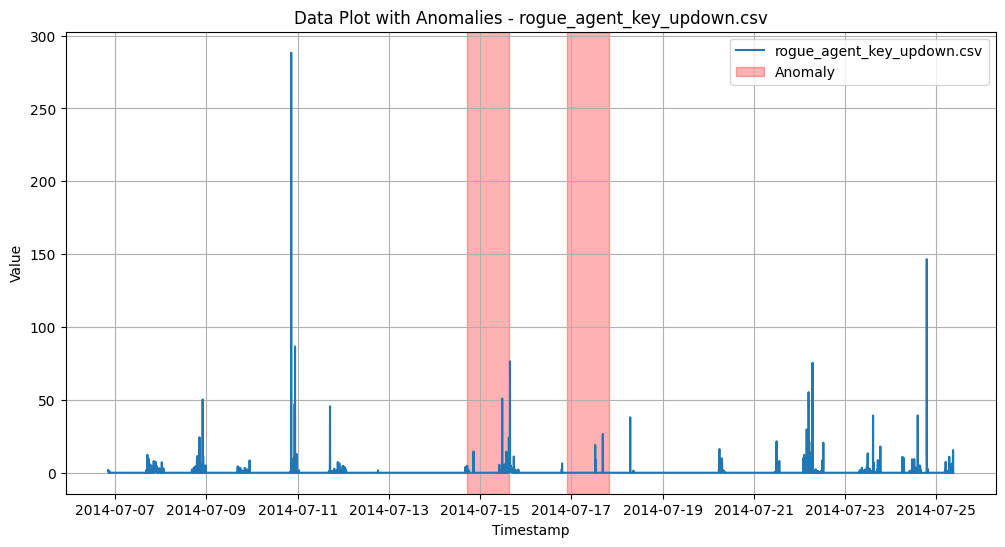

In [2]:
# 학습 데이터 디렉토리 설정
train_data_dir = './NAB/data/realKnownCause'

# 이상치 라벨 json 파일 경로 설정
anomaly_label_dir = './NAB/labels/combined_windows.json'

# 디렉토리 내의 모든 CSV 파일 불러오기
train_files = [f for f in os.listdir(train_data_dir) if f.endswith('.csv')]

# 이상치 라벨 JSON 파일 로드
with open(anomaly_label_dir, 'r') as f:
    anomaly_labels = json.load(f)

max_plot_num = 30  # 최대 몇 개 데이터까지 plot을 만들지
if len(train_files) > max_plot_num:
    train_files = train_files[:max_plot_num]

# 각 파일에 대해 데이터 로드 및 시각화
for train_file in train_files:
    train_data_file = os.path.join(train_data_dir, train_file)
    df_train = pd.read_csv(train_data_file)

    # 타임스탬프를 datetime 형식으로 변환
    df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
    df_train.set_index('timestamp', inplace=True)

    # 해당 파일의 이상치 라벨 가져오기
    # anomaly_labels의 키와 현재 파일 이름을 정확히 매칭
    # 파일의 상위 디렉토리 이름을 포함하여 상대 경로 생성
    dataset_name = os.path.basename(train_data_dir)  # 'realAWSCloudwatch'
    relative_path = f'{dataset_name}/{train_file}'

    anomaly_windows = anomaly_labels.get(relative_path, [])

    # 학습 데이터 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(df_train.index, df_train['value'], label=train_file)

    # 이상치 구간에 대해 영역 표시
    for idx, window in enumerate(anomaly_windows):
        start_time = pd.to_datetime(window[0])
        end_time = pd.to_datetime(window[1])
        plt.axvspan(start_time, end_time, color='red', alpha=0.3, label='Anomaly' if idx == 0 else "")

    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title(f'Data Plot with Anomalies - {train_file}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
df_train.index[:288] # window_size = 288

DatetimeIndex(['2014-07-06 20:10:00', '2014-07-06 20:15:00',
               '2014-07-06 20:20:00', '2014-07-06 20:25:00',
               '2014-07-06 20:35:00', '2014-07-06 20:40:00',
               '2014-07-06 20:45:00', '2014-07-06 20:50:00',
               '2014-07-06 20:55:00', '2014-07-06 21:00:00',
               ...
               '2014-07-07 19:25:00', '2014-07-07 19:30:00',
               '2014-07-07 19:35:00', '2014-07-07 19:40:00',
               '2014-07-07 19:45:00', '2014-07-07 19:50:00',
               '2014-07-07 19:55:00', '2014-07-07 20:00:00',
               '2014-07-07 20:05:00', '2014-07-07 20:10:00'],
              dtype='datetime64[ns]', name='timestamp', length=288, freq=None)

In [4]:
len(df_train[:]) % 288 # 하루 sequence 길이 = 288

131

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels, window_size, stride=1):
        """
        시계열 데이터를 윈도우 단위로 분할하여 Dataset을 구성합니다.

        Args:
            data (np.ndarray): 시계열 데이터, shape (num_samples, input_size)
            labels (np.ndarray): 시계열 데이터 라벨, shape (num_samples,)
            window_size (int): 윈도우 크기
            stride (int): 윈도우 이동 간격
        """
        self.data = data
        self.labels = labels
        self.window_size = window_size
        self.stride = stride
        self.num_samples = (len(data) - window_size) // stride + 1

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.window_size
        sample = self.data[start:end]
        target = self.data[start:end]  # 오토인코더의 경우 입력과 출력이 동일
        window_labels = self.labels[start:end]
        return (
            torch.tensor(sample, dtype=torch.float32), 
            torch.tensor(target, dtype=torch.float32), 
            torch.tensor(window_labels, dtype=torch.float32)
        )

In [6]:
set_random_seed()

# 하이퍼파라미터 및 가설 넘버 설정
args = hyperparameter_setting(N=1, batch_size=288, num_epochs=20, window_size=288, l1_lambda=0.005, limit_skip_steps=1)
h='H1'
print("Hyperparameter & Hypothesis Number Setting Complete.")

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)

model = SLAEE(
    N=args['N'], 
    input_size=args['input_size'],
    hidden_size=args['hidden_size'],
    output_size=args['output_size'],
    num_layers=args['num_layers'],
    limit_skip_steps=args['limit_skip_steps'],
    seed=args['random_seed']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print("Model Initialization Complete.")

# 데이터 준비, Dataset 및 DataLoader 생성
# file_name = './NAB/data/realKnownCause/ec2_request_latency_system_failure.csv'
file_name = './NAB/data/realKnownCause/ec2_request_latency_system_failure.csv'
abnormal_data, abnormal_label = read_dataset(file_name)
abnormal_data, abnormal_label = abnormal_data[:-1], abnormal_label[:-1] # n개 데이터 제거 -> window_size 및 batch_size에 맞추기 위함

window_size = args['window_size']
batch_size = args['batch_size']
stride = 1

# 모든 데이터를 학습에 사용
dataset = TimeSeriesDataset(abnormal_data, abnormal_label, window_size, stride=stride)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print("Data Load Complete.\n")

print("[Args]")
print(args)
print()

print("[Model]")
print(model)
print()

num_windows = len(dataset)
print("[Data]")
print(f"Number of windows: {num_windows}")
print(f"Number of samples in dataset: {len(dataset)}")
print(f"Number of batches in dataloader: {len(dataloader)}")
print()

# 손실 함수 및 옵티마이저 설정 - 논문에선 Adadelta를 사용했으나, 20 epoch 동안 loss가 떨어지지 않아 Adam으로 대체
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args['learning_rate'])
print("[Criterion & Optimizer]")
print(criterion)
print(optimizer)
print()

Hyperparameter & Hypothesis Number Setting Complete.
Model Initialization Complete.
Processing file: realKnownCause/ec2_request_latency_system_failure.csv
Data Load Complete.

[Args]
{'N': 1, 'input_size': 1, 'hidden_size': 8, 'output_size': 1, 'num_layers': 1, 'limit_skip_steps': 1, 'learning_rate': 0.001, 'l1_lambda': 0.005, 'batch_size': 288, 'window_size': 288, 'num_epochs': 20, 'random_seed': 777}

[Model]
SLAEE(
  (autoencoders): ModuleList(
    (0): AutoEncoder(
      (encoder): Encoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
      )
      (decoder): Decoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
        (output_layer): Linear(in_features=8, out_features=1, bias=True)
      )
    )
  )
)

[Data]
Number of windows: 3744
Number of samples in dataset: 3744
Number of batches in dataloader: 13

[Criterion & Optimizer]
MSELoss()
Adam (
Para

In [8]:
def train(model, dataloader, criterion, optimizer, device, l1_lambda, num_epochs, h):
    """
    For training model.

    Args:
        model (nn.Module): 학습할 모델
        dataloader (DataLoader): 학습 데이터 로더
        criterion (nn.Module): 손실 함수
        optimizer (optim.Optimizer): 옵티마이저
        device (torch.device): 학습 디바이스
        l1_lambda (float): L1 정규화 계수
        num_epochs (int): 학습 에포크 수

    Returns:
        None
    """
    
    model.train()  # 학습 모드 설정
    epoch_losses = []  # 에포크별 손실을 저장할 리스트
    
    start_time = time.time()
    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0.0
        for batch_idx, (inputs, targets, _) in enumerate(dataloader):
            inputs = inputs.to(device)  # (batch_size, window_size, input_size)
            targets = targets.to(device)  # (batch_size, window_size, input_size)

            # 입력 데이터를 모델의 예상 입력 형태로 변환
            # expected shape of input of model: (seq_len, batch_size, input_size)
            inputs = inputs.permute(1, 0, 2)  # (window_size, batch_size, input_size)
            targets = targets.permute(1, 0, 2)  # (window_size, batch_size, input_size)

            optimizer.zero_grad()

            # 모델의 forward 함수는 입력과 타겟 시퀀스를 필요로 합니다.
            outputs = model(inputs, targets)  # (seq_len, batch_size, output_size)

            # 손실 계산 (각 타임스텝별로 계산)
            loss = criterion(outputs, targets)

            # L1 정규화 추가
            l1_norm = sum(torch.norm(p, 1) for p in model.parameters())
            loss += l1_lambda * l1_norm

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        epoch_losses.append(avg_loss)  # 에포크별 평균 손실 기록
        end_time = time.time()
        if num_epochs <= 20:
            print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.6f}, (duration: {end_time-start_time:.2f}s, {time.ctime()})")
        elif num_epochs <= 100:
            if epoch % 10 == 0 or epoch == 1:
                print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.6f}, (duration: {end_time-start_time:.2f}s, {time.ctime()})")
        else:
            if epoch % 50 == 0 or epoch == 1:
                print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.6f}, (duration: {end_time-start_time:.2f}s, {time.ctime()})")

    end_time = time.time()
    print(f"Training Complete. (duration: {end_time-start_time:.2f}s)")

    # 손실 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    
    # 그래프를 파일로 저장 (선택 사항)
    plot_dir = './plots'
    os.makedirs(plot_dir, exist_ok=True)
    plot_path = os.path.join(plot_dir, f'{h}_training_loss.png')
    plt.savefig(plot_path)
    print(f"Training loss plot saved to {plot_path}")

    loss_df = pd.DataFrame({'epoch': range(1, num_epochs + 1), 'loss': epoch_losses})
    loss_path = os.path.join(plot_dir, f'{h}_training_loss.csv')
    loss_df.to_csv(loss_path, index=False)
    print(f"Training loss saved to {loss_path}")

    # 그래프 표시
    plt.show()

def test(model, dataloader, device, total_length):
    model.eval()
    all_errors = []
    all_labels = []
    
    reconstructed_sum = np.zeros((total_length,))  # 재구성 값의 합
    reconstructed_counts = np.zeros((total_length,))  # 재구성에 기여한 횟수
    
    with torch.no_grad():
        for batch_idx, (inputs, targets, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            labels = labels.numpy()
    
            # 모델 입력 형태로 변환
            inputs = inputs.permute(1, 0, 2)  # (window_size, batch_size, input_size)
            targets = targets.permute(1, 0, 2)
    
            # 모델 예측
            outputs = model(inputs, targets)  # (seq_len, batch_size, output_size)
    
            # 출력 형태 복원
            outputs = outputs.permute(1, 0, 2).cpu().numpy()  # (batch_size, window_size, output_size)
            targets = targets.permute(1, 0, 2).cpu().numpy()
    
            batch_size = outputs.shape[0]
            for i in range(batch_size):
                idx = batch_idx * dataloader.batch_size + i
                start = idx * dataloader.dataset.stride
                end = start + dataloader.dataset.window_size
                # 재구성 값 합산
                reconstructed_sum[start:end] += outputs[i,:,0]
                # 재구성 횟수 카운트
                reconstructed_counts[start:end] += 1
    
                # MSE 계산
                mse = np.mean((outputs[i,:,0] - targets[i,:,0])**2)
                all_errors.append(mse)
                all_labels.extend(labels[i])
    
    # 평균 재구성 값 계산
    reconstructed_data = reconstructed_sum / reconstructed_counts
    
    all_errors = np.array(all_errors)
    all_labels = np.array(all_labels)
    
    return all_errors, all_labels, reconstructed_data

Epoch [1/20], Loss: 0.853433, (duration: 16.38s, Thu Nov 21 23:59:06 2024)
Epoch [2/20], Loss: 0.770958, (duration: 31.51s, Thu Nov 21 23:59:21 2024)
Epoch [3/20], Loss: 0.703680, (duration: 46.69s, Thu Nov 21 23:59:36 2024)
Epoch [4/20], Loss: 0.649940, (duration: 61.78s, Thu Nov 21 23:59:51 2024)
Epoch [5/20], Loss: 0.602874, (duration: 76.93s, Fri Nov 22 00:00:06 2024)
Epoch [6/20], Loss: 0.560725, (duration: 93.04s, Fri Nov 22 00:00:23 2024)
Epoch [7/20], Loss: 0.524078, (duration: 109.11s, Fri Nov 22 00:00:39 2024)
Epoch [8/20], Loss: 0.489014, (duration: 126.51s, Fri Nov 22 00:00:56 2024)
Epoch [9/20], Loss: 0.454628, (duration: 143.06s, Fri Nov 22 00:01:13 2024)
Epoch [10/20], Loss: 0.423063, (duration: 159.03s, Fri Nov 22 00:01:29 2024)
Epoch [11/20], Loss: 0.393672, (duration: 175.42s, Fri Nov 22 00:01:45 2024)
Epoch [12/20], Loss: 0.365610, (duration: 191.52s, Fri Nov 22 00:02:01 2024)
Epoch [13/20], Loss: 0.339173, (duration: 206.88s, Fri Nov 22 00:02:16 2024)
Epoch [14/20],

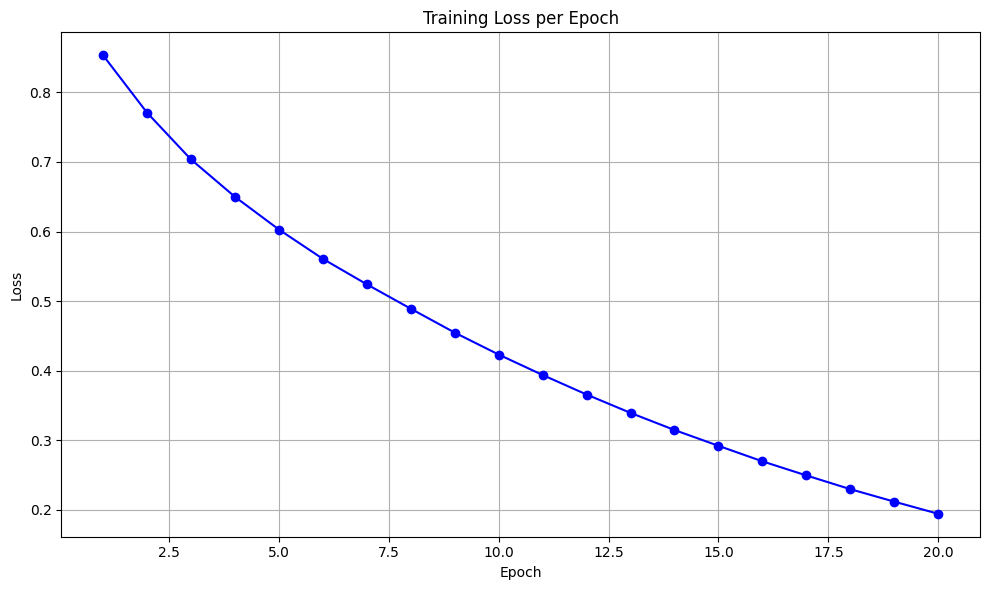

In [9]:
# 학습 실행
train(
    model=model,
    dataloader=dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    l1_lambda=args['l1_lambda'],
    num_epochs=args['num_epochs'],
    h=h
)
# LSTM+AE+GARCH -> 100 epoch, 0.002721 loss

In [14]:
# 모델 가중치 저장
torch.save(model.state_dict(), f'{h}_ensemble_autoencoder_weights.pth')
print(f"모델 가중치가 {h}_ensemble_autoencoder_weights.pth'에 저장되었습니다.")

모델 가중치가 H1_ensemble_autoencoder_weights.pth'에 저장되었습니다.


# Test

Testing Complete.

Actual vs Reconstructed data plot saved to ./plots\H1_actual_vs_reconstructed.png


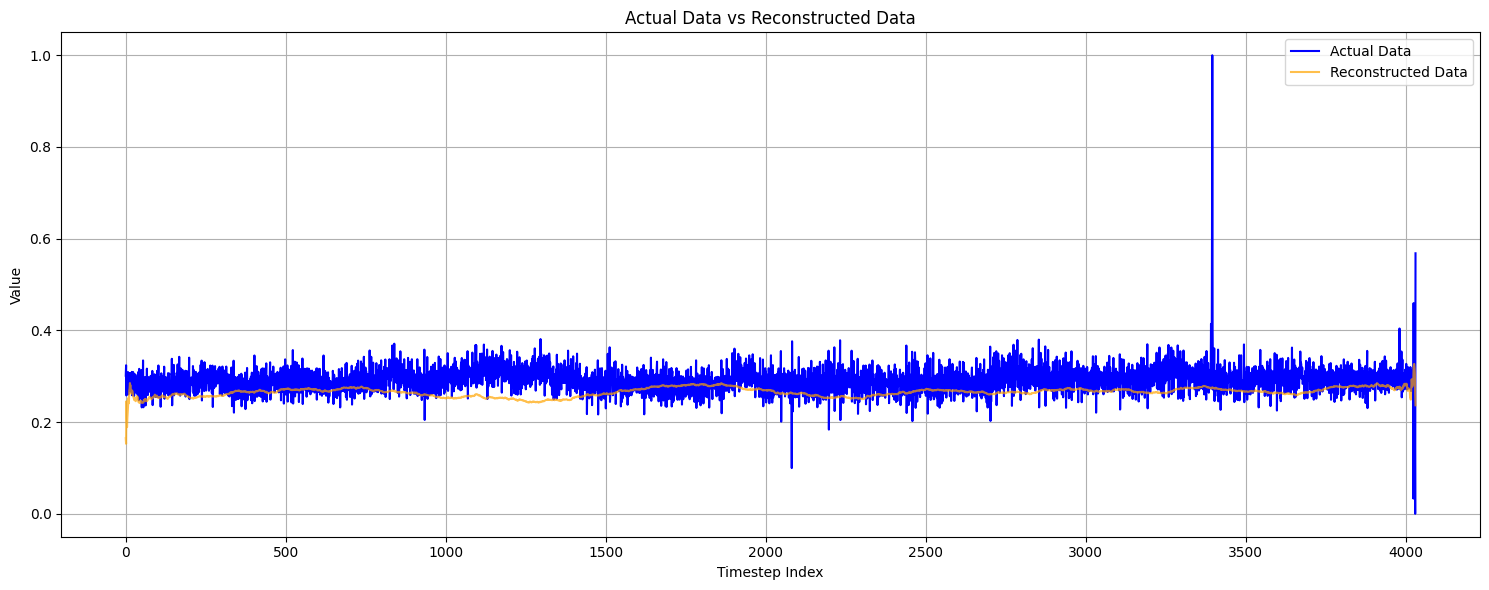

In [10]:
# 테스트 실행 (모든 데이터를 사용)
# 원본 데이터의 전체 길이
total_length = len(abnormal_data)
test_errors, test_labels, reconstructed_data = test(
    model=model,
    dataloader=dataloader,
    device=device,
    total_length=total_length
)

print("Testing Complete.\n")

# 실제 데이터
actual_data = abnormal_data

# 재구성 데이터
predicted_data = reconstructed_data

# 플롯
plt.figure(figsize=(15, 6))
plt.plot(actual_data, label='Actual Data', color='blue')
plt.plot(predicted_data, label='Reconstructed Data', color='orange', alpha=0.7)
plt.title('Actual Data vs Reconstructed Data')
plt.xlabel('Timestep Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 그래프를 파일로 저장
plot_dir = './plots'
os.makedirs(plot_dir, exist_ok=True)
plot_path = os.path.join(plot_dir, f'{h}_actual_vs_reconstructed.png')
plt.savefig(plot_path)
print(f"Actual vs Reconstructed data plot saved to {plot_path}")

# 그래프 표시
plt.show()

In [13]:
# 라벨 분포 확인
unique, counts = np.unique(test_labels, return_counts=True)
label_distribution = dict(zip(unique, counts))
print("Label Distribution:", label_distribution)

# 라벨 변환: -1 (Anomaly) -> 1, 그 외 -> 0
binary_labels = np.where(test_labels == -1, 1, 0)

# 라벨 분포 다시 확인
unique, counts = np.unique(binary_labels, return_counts=True)
binary_label_distribution = dict(zip(unique, counts))
print("Binary Label Distribution:", binary_label_distribution)

# 재구성 오차 기준으로 이상치 예측 (Threshold 설정)
# 예시: 재구성 오차의 95% 백분위수
threshold = np.percentile(test_errors, 95)
print(f"Reconstruction Error Threshold: {threshold:.6f}")

# 이상치 예측
predictions = (test_errors > threshold).astype(int)

# True Positives (TP): 실제 이상치이고, 예측도 이상치인 경우
TP = (binary_labels == 1) & (predictions == 1)
# False Positives (FP): 실제 정상인데, 예측은 이상치인 경우
FP = (binary_labels == 0) & (predictions == 1)
# False Negatives (FN): 실제 이상치인데, 예측은 정상인 경우
FN = (binary_labels == 1) & (predictions == 0)
# True Negatives (TN): 실제 정상이고, 예측도 정상인 경우 (선택 사항)
TN = (binary_labels == 0) & (predictions == 0)

# 분류 지표 계산
precision = precision_score(binary_labels, predictions, zero_division=0)
recall = recall_score(binary_labels, predictions, zero_division=0)
f1 = f1_score(binary_labels, predictions, zero_division=0)
try:
    roc_auc = roc_auc_score(binary_labels, test_errors)
    pr_auc = average_precision_score(binary_labels, test_errors)
except ValueError as e:
    print(f"ROC AUC and PR AUC cannot be calculated: {e}")
    roc_auc = None
    pr_auc = None
cohen_kappa = cohen_kappa_score(binary_labels, predictions)

print("[Classification Metrics]")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
if roc_auc is not None:
    print(f"ROC AUC: {roc_auc:.4f}")
else:
    print("ROC AUC: Undefined")
if pr_auc is not None:
    print(f"PR AUC: {pr_auc:.4f}")
else:
    print("PR AUC: Undefined")
print(f"Cohen Kappa: {cohen_kappa:.4f}")
print()

# 재구성 오차 시각화
plt.figure(figsize=(15, 6))
plt.plot(test_errors, label='Reconstruction Error', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

# True Positives (TP): 실제 이상치이고, 예측도 이상치인 경우
plt.scatter(np.where(TP)[0], test_errors[TP], marker='o', color='green', label='True Positives (TP)')
# False Positives (FP): 실제 정상인데, 예측은 이상치인 경우
plt.scatter(np.where(FP)[0], test_errors[FP], marker='x', color='orange', label='False Positives (FP)')
# False Negatives (FN): 실제 이상치인데, 예측은 정상인 경우
plt.scatter(np.where(FN)[0], test_errors[FN], marker='x', color='purple', label='False Negatives (FN)')
# True Negatives (TN): 실제 정상이고, 예측도 정상인 경우 (선택 사항)
# plt.scatter(np.where(TN)[0], test_errors[TN], marker='.', color='grey', label='True Negatives (TN)')

# dataset_name = os.path.basename(file_name)
# relative_path = f'{dataset_name}/{file_name}'

anomaly_windows = anomaly_labels.get('realTweets/Twitter_volume_CVS.csv', [])

# 이상치 구간에 대해 영역 표시
for idx, window in enumerate(anomaly_windows):
    start_time = pd.to_datetime(window[0])
    end_time = pd.to_datetime(window[1])
    plt.axvspan(start_time, end_time, color='red', alpha=0.3, label='Anomaly' if idx == 0 else "")

plt.title('Reconstruction Error with Anomaly Detection')
plt.xlabel('Timestep Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 그래프를 파일로 저장 (변수 h가 정의되어 있다고 가정)
plot_dir = './plots'
os.makedirs(plot_dir, exist_ok=True)
plot_path = os.path.join(plot_dir, f'{h}_reconstruction_error_all_data.png')
plt.savefig(plot_path)
print(f"Reconstruction error plot saved to {plot_path}")

# 그래프 표시 (필요 시)
plt.show()

# ROC Curve 시각화
if roc_auc is not None:
    fpr, tpr, _ = roc_curve(binary_labels, test_errors)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    roc_plot_path = os.path.join(plot_dir, f'{h}_roc_curve_all_data.png')
    plt.savefig(roc_plot_path)
    print(f"ROC curve plot saved to {roc_plot_path}")

    plt.show()

# PR Curve 시각화
if pr_auc is not None:
    precision_vals, recall_vals, _ = precision_recall_curve(binary_labels, test_errors)
    plt.figure(figsize=(10, 6))
    plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.4f})', color='navy')
    plt.title('Precision-Recall (PR) Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    pr_plot_path = os.path.join(plot_dir, f'{h}_pr_curve_all_data.png')
    plt.savefig(pr_plot_path)
    print(f"PR curve plot saved to {pr_plot_path}")

    plt.show()

Label Distribution: {np.float32(-1.0): np.int64(438624), np.float32(1.0): np.int64(4043808)}
Binary Label Distribution: {np.int64(0): np.int64(4043808), np.int64(1): np.int64(438624)}
Reconstruction Error Threshold: 0.003203


MemoryError: Unable to allocate 65.0 GiB for an array with shape (4482432, 15564) and data type bool

In [ ]:
from srnn_ae import SLAEE, set_random_seed, hyperparameter_setting, read_dataset
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    roc_auc_score, average_precision_score, cohen_kappa_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import time

set_random_seed()

# 하이퍼파라미터 및 가설 넘버 설정
args = hyperparameter_setting(N=1, batch_size=5188, num_epochs=300)
h='H1'
print("Hyperparameter & Hypothesis Number Setting Complete.")

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)

model = SLAEE(
    N=args['N'], 
    input_size=args['input_size'],
    hidden_size=args['hidden_size'],
    output_size=args['output_size'],
    num_layers=args['num_layers'],
    limit_skip_steps=args['limit_skip_steps'],
    seed=args['random_seed']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print("Model Initialization Complete.")

# 데이터 준비, Dataset 및 DataLoader 생성
file_name = './NAB/data/realTweets/Twitter_volume_CVS.csv'
abnormal_data, abnormal_label = read_dataset(file_name)
abnormal_data, abnormal_label = abnormal_data[:-2], abnormal_label[:-2] # n개 데이터 제거 -> window_size 및 batch_size에 맞추기 위함

window_size = args['window_size']
batch_size = args['batch_size']
stride = 1

# 모든 데이터를 학습에 사용 (비중첩 슬라이딩 윈도우)
dataset = TimeSeriesDataset(abnormal_data, abnormal_label, window_size, stride=stride)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print("Data Load Complete.\n")

print("[Args]")
print(args)
print()

print("[Model]")
print(model)
print()

num_windows = len(dataset)
print("[Data]")
print(f"Number of windows: {num_windows}")
print(f"Number of samples in dataset: {len(dataset)}")
print(f"Number of batches in dataloader: {len(dataloader)}")
print()

# 손실 함수 및 옵티마이저 설정 - 논문에선 Adadelta를 사용했으나, 20 epoch 동안 loss가 떨어지지 않아 Adam으로 대체
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args['learning_rate'])
print("[Criterion & Optimizer]")
print(criterion)
print(optimizer)
print()

model.load_state_dict(torch.load(f'{h}_ensemble_autoencoder_weights.pth', weights_only=True))
print("모델 가중치가 로드되었습니다.")